In [1]:
import random
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import os
import cv2
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.metrics import structural_similarity as ss
import utils

### Principal functions

In [2]:
# load image from url
def load_target_image(image_url, color=True, size=None):
  image_path = "target_image"    
  urllib.request.urlretrieve(image_url,image_path)
  # Apply color
  if color:
      target = cv2.imread(image_path, cv2.IMREAD_COLOR)
      target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
  else:
      # Apply gray scale
      target = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if size:
      # Only resizes image if it is needed!
      target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
  return target

In [3]:
# Helps to show image
def show_image(img_arr):    
  plt.figure(figsize=(6, 6))
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.show()

In [4]:
# Show results
def show_results(history, img_arr, org):
  plt.figure(figsize=(10,10))
  plt.tight_layout()

  plt.subplot(221)
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.title('BEST of generation')

  plt.subplot(222)
  plt.axis("off")
  plt.imshow(org/255)
  plt.title('Target image')

  plt.subplot(212)
  lh = len(history)
  plt.xlim([lh-50, lh])
  plt.plot(history)
  plt.title('MIN fitness by generation') 
  plt.show()

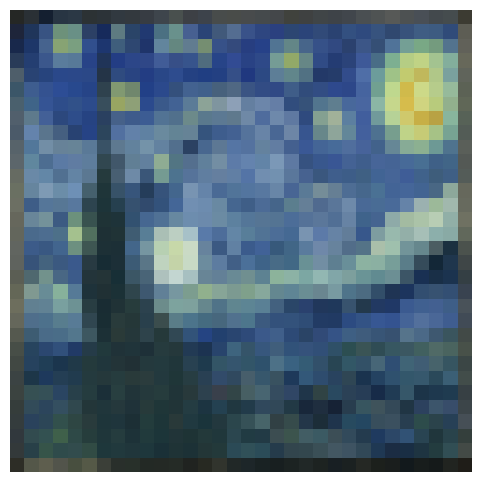

(32, 32, 3)


In [5]:
report_every_gen = 10
number_generations = 1000
polygons = 255
size = 32
target_image = "Art"


POLYGONS = polygons
SIZE = (size, size)

target_urls = utils.target_urls

target_image_url = target_urls[target_image]
target = load_target_image(target_image_url, size=SIZE)
show_image(target)
print(target.shape)

In [6]:
GENE_LENGTH = 10
NUM_GENES = POLYGONS * GENE_LENGTH

# Create individual
individual = np.random.uniform(0,1,NUM_GENES)
print(individual)

[0.27005657 0.25756022 0.71934897 ... 0.12663306 0.60161862 0.43699425]


In [7]:
def extract_genes(genes, length): 
    for i in range(0, len(genes), length): 
        yield genes[i:i + length]

In [8]:
def render_individual(individual):
  if isinstance(individual,list):
    individual = np.array(individual)
  canvas = np.zeros(SIZE+(3,))
  radius_avg = (SIZE[0] + SIZE[1]) / 2 / 6
  genes = extract_genes(individual, GENE_LENGTH)
  for gene in genes:
    try:
      overlay = canvas.copy()
      x1 = int(gene[0] * SIZE[0])
      x2 = int(gene[2] * SIZE[0])
      x3 = int(gene[4] * SIZE[0])
      y1 = int(gene[1] * SIZE[1])
      y2 = int(gene[3] * SIZE[1])
      y3 = int(gene[5] * SIZE[1])
      color = (gene[6:-1] * 255).astype(int).tolist() 
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]], np.int32)  
      pts = pts.reshape((-1, 1, 2))
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]])

      cv2.fillPoly(overlay, [pts], color)
      alpha = gene[-1]
      canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)  
    except:
      pass
  return canvas

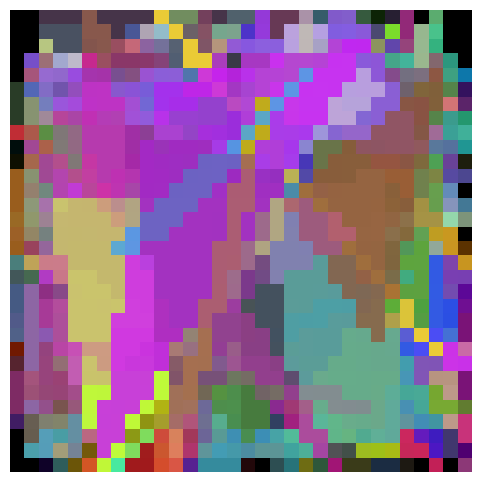

In [9]:
# Show individual
render = render_individual(individual)
show_image(render)

### Metrics

In [10]:
def fitness_mse(render):
  """Calculates Mean Square Error Fitness for a render"""
  error = (np.square(render - target)).mean(axis=None)
  return error

In [11]:
def fitness_ss(render):
  """Calculated Structural Similiarity Fitness"""
  index = ss(render, target, multichannel=True)
  return 1-index

In [12]:
print(fitness_mse(render))

5680.535282674317


In [13]:
# Apply Hyperparameters
IND_SIZE = NUM_GENES
MIN_VALUE = -1
MAX_VALUE = 1
MIN_STRATEGY = 0.5
MAX_STRATEGY = 5

CXPB = .6
MUTPB = .3

### Setting up creator

In [14]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", list, typecode="d")

In [15]:

def generateES(icls, scls, size, imin, imax, smin, smax):  
  ind = icls(random.uniform(imin, imax) for _ in range(size))  
  ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))  
  return ind

def checkStrategy(minstrategy):
  def decorator(func):
    def wrappper(*args, **kargs):
      children = func(*args, **kargs)
      for child in children:
        for i, s in enumerate(child.strategy):
          if s < minstrategy:
            child.strategy[i] = minstrategy
      return children
    return wrappper
  return decorator

In [16]:

def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [17]:

def clamp(low, up, n):
  return max(low, min(n, up))

def custom_blend(ind1, ind2, alpha):    
    for i, (x1, s1, x2, s2) in enumerate(zip(ind1, ind1.strategy,
                                             ind2, ind2.strategy)):
        # Blend the values
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i] = clamp(0.0, 1.0, (1. - gamma) * x1 + gamma * x2)
        ind2[i] = clamp(0.0, 1.0, gamma * x1 + (1. - gamma) * x2)
        # Blend the strategies
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1.strategy[i] = (1. - gamma) * s1 + gamma * s2
        ind2.strategy[i] = gamma * s1 + (1. - gamma) * s2
        

    return ind1, ind2

In [18]:
toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", custom_blend, alpha=0.5)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.06)

# Register the "select" alias to a tournament selection function ('tools.selTournament') with a tournament size of 5.
# This function is used to select individuals from the population based on their fitness.
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

In [19]:

def evaluate(individual):
  render = render_individual(individual)
  print('.', end='')
  return fitness_mse(render),

In [20]:
toolbox.register("evaluate", evaluate)

In [21]:

random.seed(64)
    
NGEN = number_generations
RGEN = report_every_gen
CXPB = .6
MUTPB = .3
MU, LAMBDA = 100, 250
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

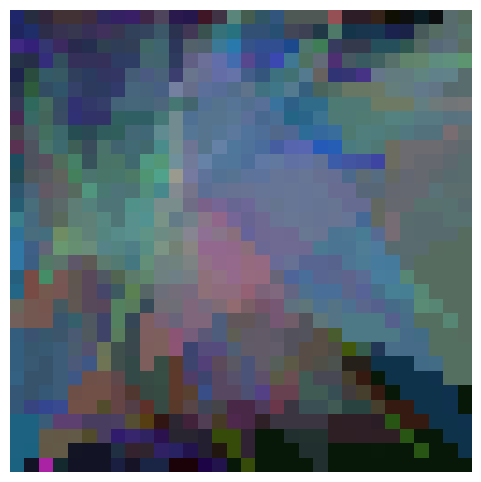

Gen (30) : best fitness = 1324.7742964045242


In [22]:
best = None
history = []

for g in range(NGEN):
    clear_output(wait=True)  # Limpiar la salida antes de mostrar la nueva imagen y resultados
  
    pop, logbook = algorithms.eaMuCommaLambda(
        pop, toolbox, mu=MU, lambda_=LAMBDA, 
        cxpb = CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, 
        halloffame=hof, verbose=False
    )
  
    best = hof[0]

    render = render_individual(best)
    show_image(render)
    history.extend([clamp(0.0, 5000.0, l["min"]) for l in logbook])
    # show_results(history, render, target)
    print(f"Gen ({(g+1)*RGEN}) : best fitness = {fitness_mse(render)}")